In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from FewShotTestHandler import extract_test_result_sequence

/home/rob/vlm_benchmark/FewShotTestHandler.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
test_results = pd.read_csv("test_results.csv")

In [5]:
def column_value_formatter(col, val):
    # Format value
    if col == "vlm_class":
        transform = {
            "ClipVLM": "CLIP",
            "MILES_SimilarityVLM": "MILES",
            "VideoClipVLM": "VideoCLIP"
        }
        return transform.get(val, val)
    
    if col == "dataset":
        name, split = val.split(".")
            
        transform = {
            "kinetics_100": "Kinetics-100",
            "moma_act": "MOMA Activity",
            "moma_sact": "MOMA Sub-Activity"
        }
        
        result = transform.get(name, name)
        if split != "all":
            result += f" ({split})"
        return result
    
    if col == "n_way":
        return f"{val}-way"
    
    if col == "n_support":
        return f"{val}-shot"
    
    if col == "classifier.text_weight":
        return f"text_weight: {val}"
    
    return f"{col}: {val}"

def column_description(col):
    if col == "n_support":
        return "Support Videos"
    
    if col == "classifier.text_weight":
        return "Text Weight"
    
    return col

In [6]:
def plot(results, x_col, y_col, plot_descriptor_cols, line_descriptor_cols, filter_dict = {}):
    grouped_results = extract_test_result_sequence(results, x_col, y_col, filter=filter_dict)
    print(f"{len(grouped_results)} Overall Lines")
    
    plot_descriptors = grouped_results.reset_index().groupby(plot_descriptor_cols, as_index=False, dropna=False).agg({"index": list})
    print(f"{len(plot_descriptors)} Separate Plots")
    
    for plot_descriptor in plot_descriptors.itertuples():
        plot_name = ", ".join([column_value_formatter(col, getattr(plot_descriptor, col)) for col in plot_descriptor_cols])
        
        fig, ax = plt.subplots(figsize=(8,4))
        fig.suptitle(plot_name, fontsize=15)
        
        lines = grouped_results.loc[plot_descriptor.index].reset_index()
        
        for i in range(len(lines)):
            line_name = ", ".join([column_value_formatter(col, lines.loc[i, col]) for col in line_descriptor_cols])
                
            x, y = lines.loc[i, [x_col, y_col]]
        
            if x_col == "classifier.text_weight" and lines.loc[i, "n_support"] == 0 and len(x) == 1:
                ax.axhline(y[0], label=line_name, linestyle="dashed")
            elif "classifier.text_weight" in line_descriptor_cols and x_col == "n_support" and x[0] == 0:
                ax.scatter([x[0]], [y[0]])
                ax.plot(x[1:], y[1:], label=line_name)
            else:
                ax.plot(x, y, label=line_name)
        
        ax.set_xlabel(column_description(x_col))
        ax.set_ylabel(column_description(y_col))
        if len(lines) > 6:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend()
        fig.show()

In [7]:
# Default filter dict
filter_dict = {
    "classifier_class": ["WeightedTextFewShotClassifier"],
    "dataset": ["kinetics_100.all", "moma_act.all", "moma_sact.all"],
    "n_way": [5, 50],
    "classifier.text_weight": [0, 0.1, 0.5, 1, 5, 10]
}

315 Overall Lines
15 Separate Plots


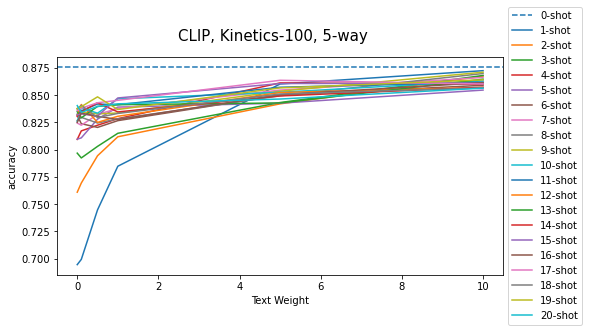

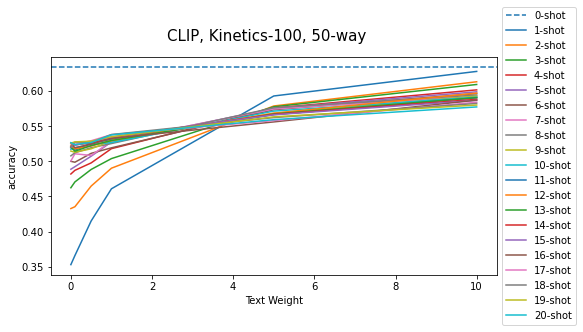

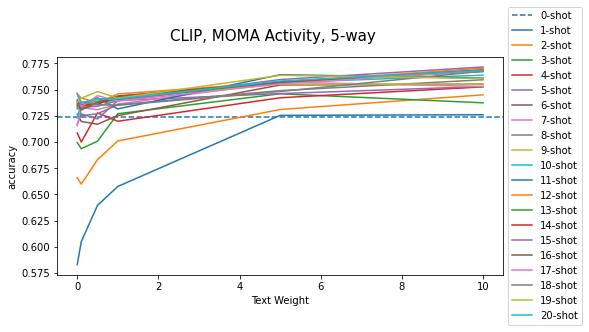

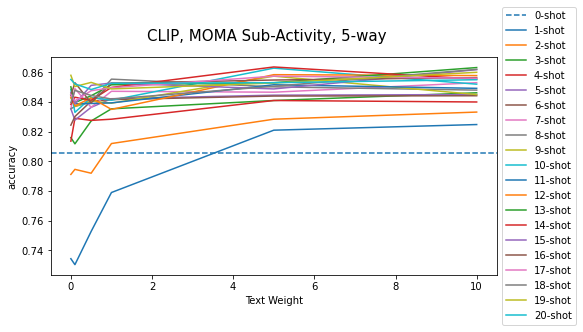

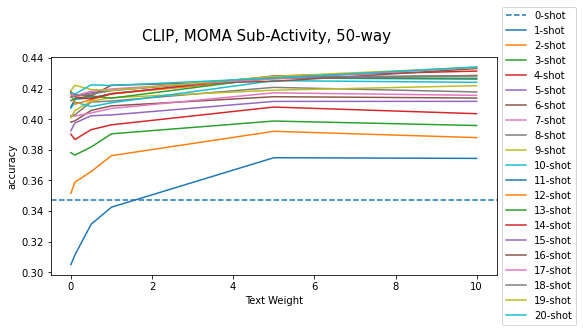

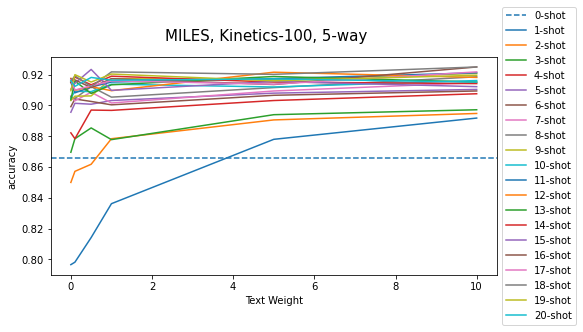

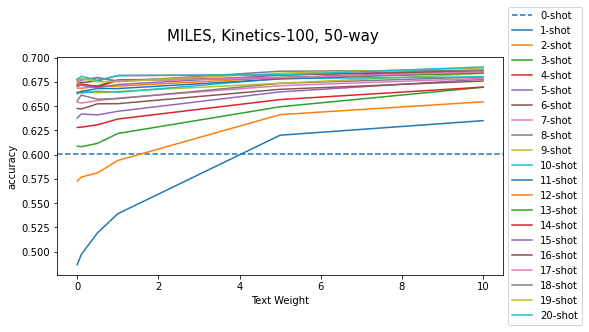

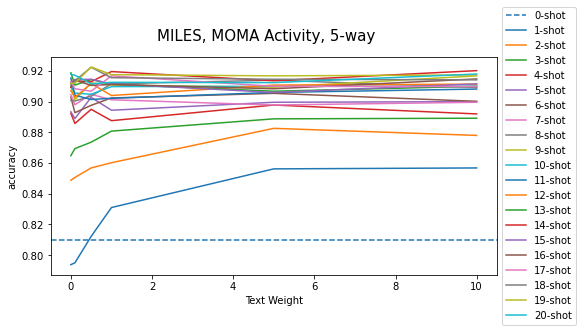

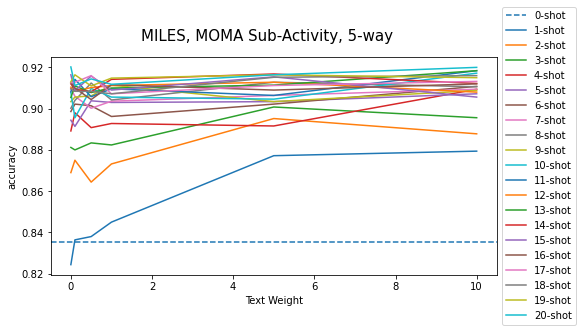

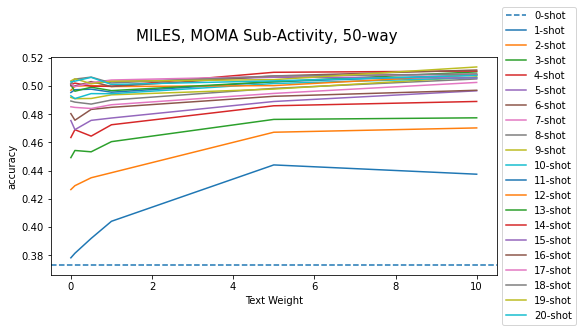

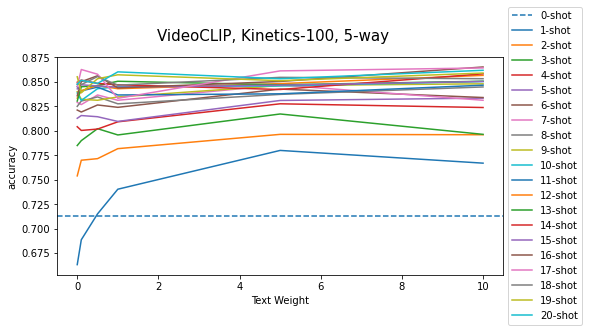

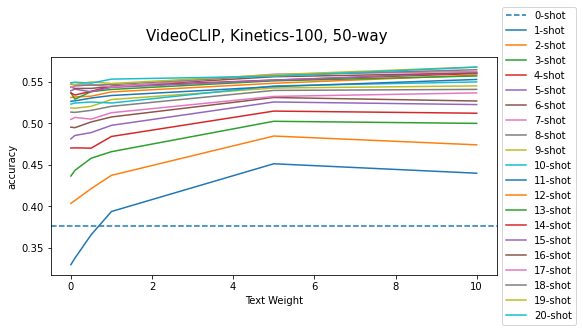

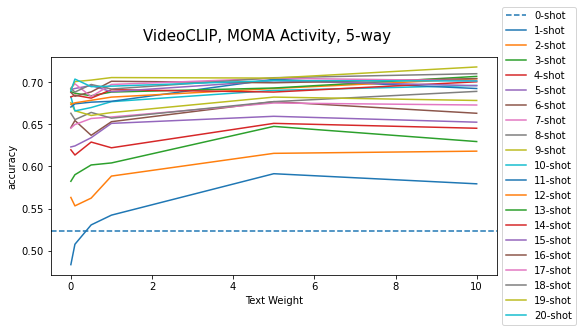

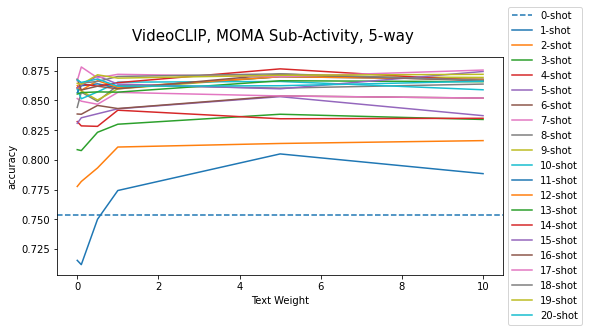

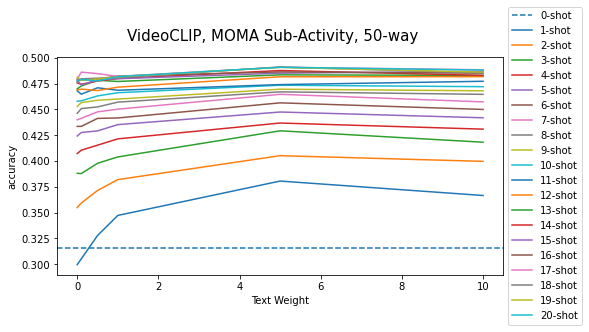

In [8]:
x_col = "classifier.text_weight"
y_col = "accuracy"
plot_descriptor_cols = ["vlm_class", "dataset", "n_way"]    # Create a separate plot for each value of these
line_descriptor_cols = ["n_support"]                        # Create a separate line (with these cols as legend) for each unique val of these

plot(test_results, x_col, y_col, plot_descriptor_cols, line_descriptor_cols, filter_dict)

90 Overall Lines
15 Separate Plots


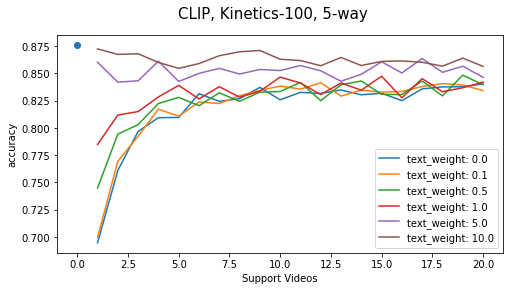

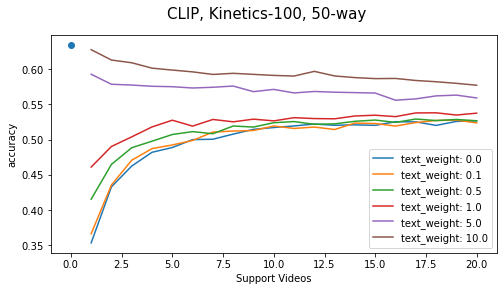

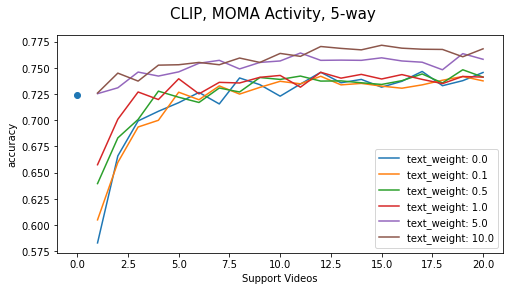

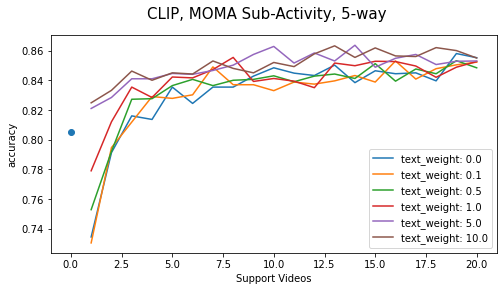

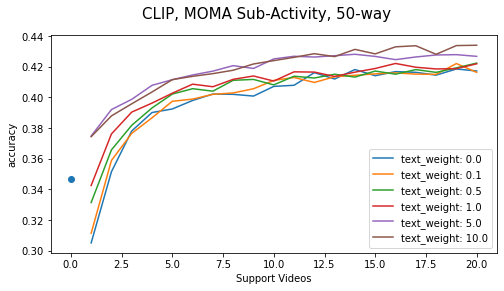

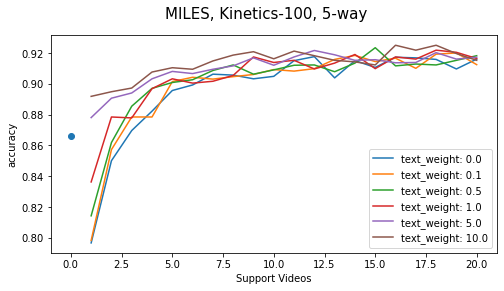

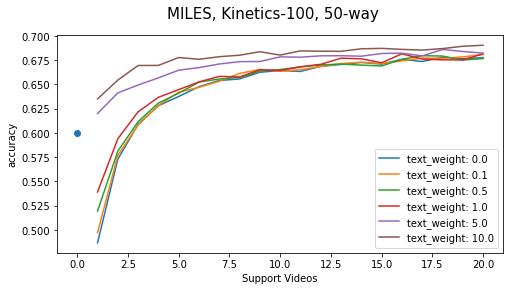

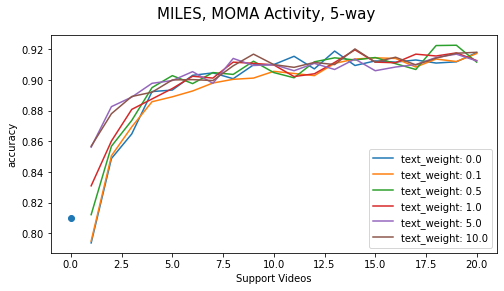

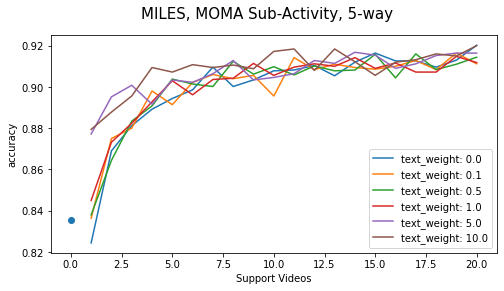

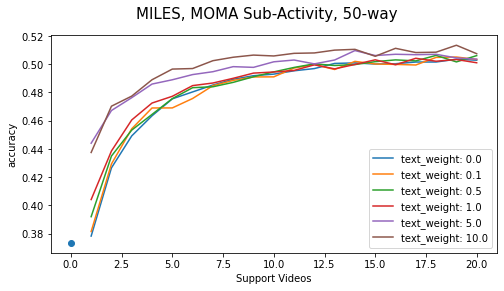

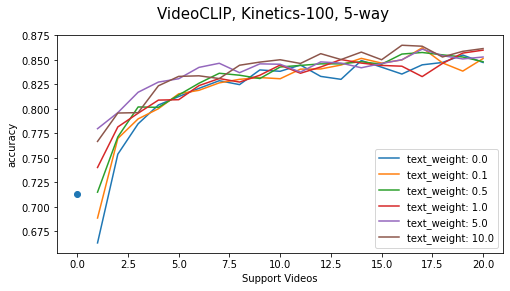

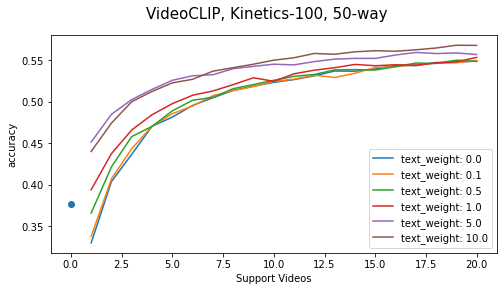

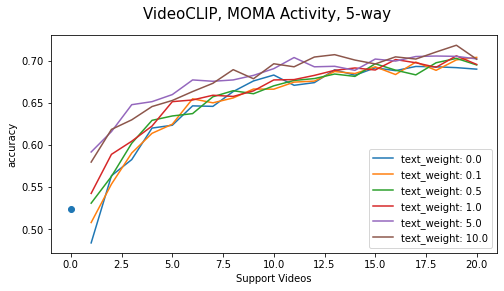

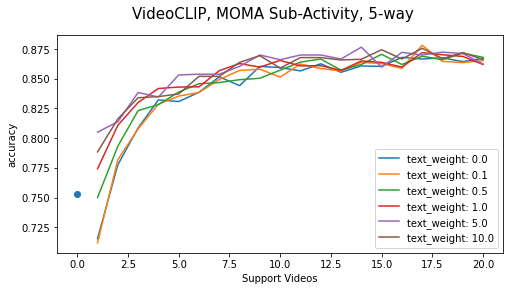

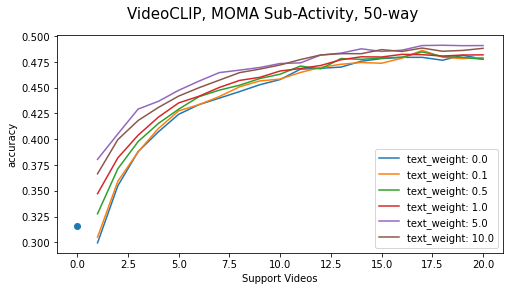

In [9]:
x_col = "n_support"
y_col = "accuracy"
plot_descriptor_cols = ["vlm_class", "dataset", "n_way"]    # Create a separate plot for each value of these
line_descriptor_cols = ["classifier.text_weight"]           # Create a separate line (with these cols as legend) for each unique val of these

plot(test_results, x_col, y_col, plot_descriptor_cols, line_descriptor_cols, filter_dict)

9 Overall Lines
3 Separate Plots


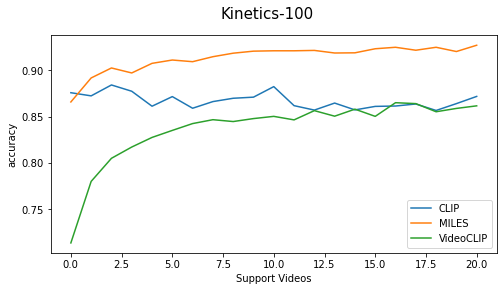

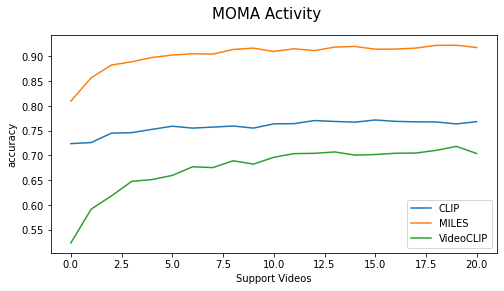

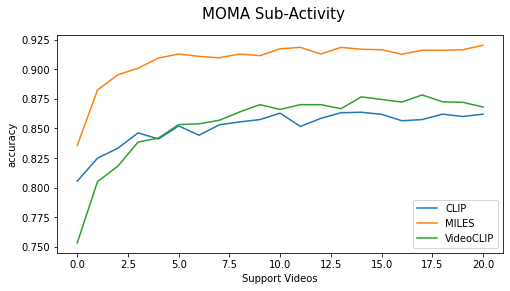

In [10]:
# Maximize over text_weights, then group vlms into the same plots
agg_results = test_results.groupby(
    [col for col in test_results.columns if col not in ["classifier.text_weight", "accuracy"]],
    as_index=False, dropna=False
).agg({"accuracy": "max"})

new_filter = dict(filter_dict, n_way=[5])

x_col = "n_support"
y_col = "accuracy"
plot_descriptor_cols = ["dataset"]#, "n_way"]    # Create a separate plot for each value of these
line_descriptor_cols = ["vlm_class"]           # Create a separate line (with these cols as legend) for each unique val of these

plot(agg_results, x_col, y_col, plot_descriptor_cols, line_descriptor_cols, new_filter)

In [25]:
temp_filter_dict = dict(filter_dict, n_support=[0, 1, 5])
temp_filter_dict["n_way"] = [5]
filtered_indices = np.ones(len(test_results)).astype(bool)
for filter_col, filter_val_list in temp_filter_dict.items():
    if filter_col not in test_results.columns:
        continue
    
    valid_col_indices = np.zeros(len(test_results)).astype(bool)
    for filter_val in filter_val_list:
        valid_col_indices = valid_col_indices | (test_results[filter_col] == filter_val)
    filtered_indices = filtered_indices & valid_col_indices
temp_results = test_results[filtered_indices]    

temp_results = temp_results.groupby(
    [col for col in temp_results.columns if col not in ["classifier.text_weight", "accuracy"]],
    as_index=False, dropna=False
).agg({"accuracy": "max"})

In [26]:
temp_results.to_csv("temp.csv")

In [17]:
from dataset import DatasetHandler
dataset = DatasetHandler("moma_act", "all")
print(len(dataset.data_dict))
print(sum([len(vids) for vids in dataset.data_dict.values()]))
print(dataset.data_dict.keys())

momaapi.lookup._read_anns() took 0.8899693489074707 sec
momaapi.statistics._read_statistics() took 0.0005168914794921875 sec
20
1412
dict_keys(['awards ceremony', 'babysitting', 'basketball game', 'beauty salon service', 'bike lesson', 'car racing pitstop', 'dining', 'drive-thru ordering', 'field sobriety test', 'firefighting', 'frisbee game', 'haircut', 'marriage proposal', 'medical injection', 'physical therapy', 'piano lesson', 'reception service', 'security screening', 'soccer game', 'table tennis game'])


In [19]:
dataset = DatasetHandler("moma_sact", "all")
print(len(dataset.data_dict))
print(sum([len(vids) for vids in dataset.data_dict.values()]))
print(dataset.data_dict.keys())

momaapi.lookup._read_anns() took 0.9018402099609375 sec
momaapi.statistics._read_statistics() took 0.0005753040313720703 sec
91
15842
dict_keys(['one person is on their knees while proposing', 'one person is putting a ring on their partner', 'players are trying to catch a frisbee', 'the adult is chasing after the child on the bike', 'the adult is comforting the child', 'the adult is explaining to the child how to ride a bike', 'the adult is feeding the child', 'the adult is holding the child on the bike', 'the adult is playing with the child', 'the adult is pushing the stroller', "the adult is wrapping the child or changing the child's diaper or clothes", 'the audience and host are cheering the award recipient on stage', 'the award winner is delivering a speech on stage', 'the barber is applying shampoo', 'the barber is combing hair', 'the barber is cutting hair with a razor', 'the barber is cutting hair with scissors', 'the barber is drying hair', "the barber is massaging the customer